Tutorial 2: Mappers
===================

In the previous example, we made a `Mapper` from a rectangular `Pixelization`. However, it wasn`t clear what a _Mapper_
was actually mapping. Infact, it didn`t do much mapping at all! Therefore, in this tutorial, we'll cover mapping.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use new strong lensing data, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

Now, lets set up our `Grid2D`'s (using the image above).

In [3]:
grid = al.Grid2D.uniform(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, sub_size=1
)

Our `Tracer` will use the same lens galaxy and source galaxy that we used to Simulate the `Imaging` data (although, 
becuase we're modeling the source with a pixel-grid, we don't need to supply its `LightProfile`..

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=grid)[1]

Next, we setup our `Pixelization` and `Mapper` using the tracer`s source-plane grid.

In [5]:
rectangular = al.pix.Rectangular(shape=(25, 25))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

we're going to plot our `Mapper` alongside the image we used to generate the source-plane grid.

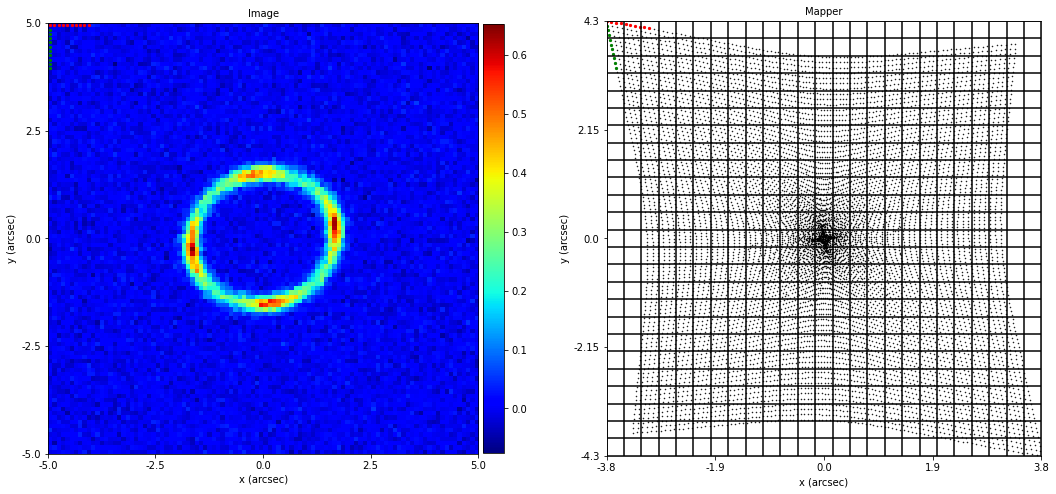

In [6]:
visuals_2d = aplt.Visuals2D(
    indexes=[
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    ]
)
include_2d = aplt.Include2D(mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)
mapper_plotter.subplot_image_and_mapper(image=imaging.image)

The pixels in the image map to the pixels in the source-plane, and visa-versa. Lets highlight a set of image-pixels in 
both the image and source-plane.

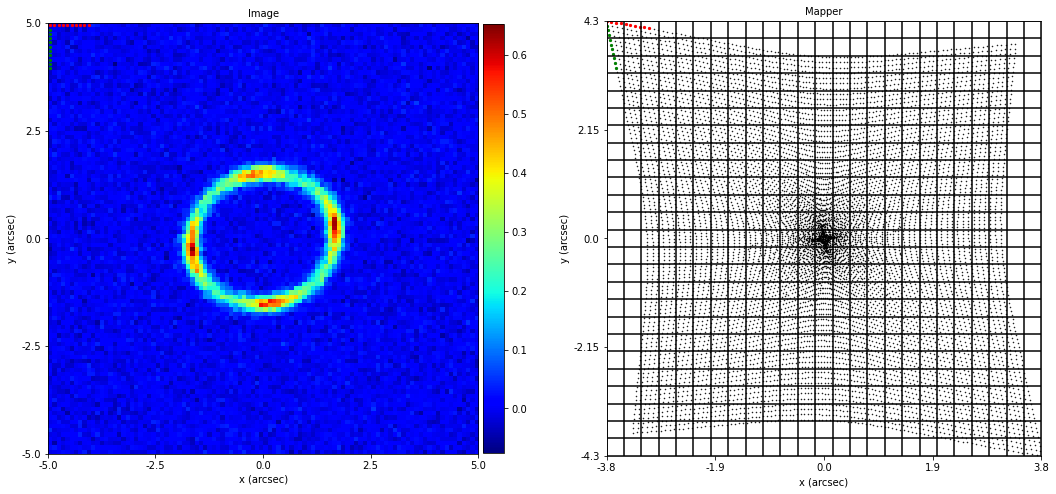

In [7]:
mapper_plotter.subplot_image_and_mapper(image=imaging.image)

That`s nice, and we can see the mappings, but it isn't really what we want to know, is it? We really want to go the 
other way, and see how our source-pixels map to the image. This is where `Mapper`'s come into their own, as they let us 
map all the points in a given source-pixel back to the image. Lets map source pixel 313, the central source-pixel, 
to the image.

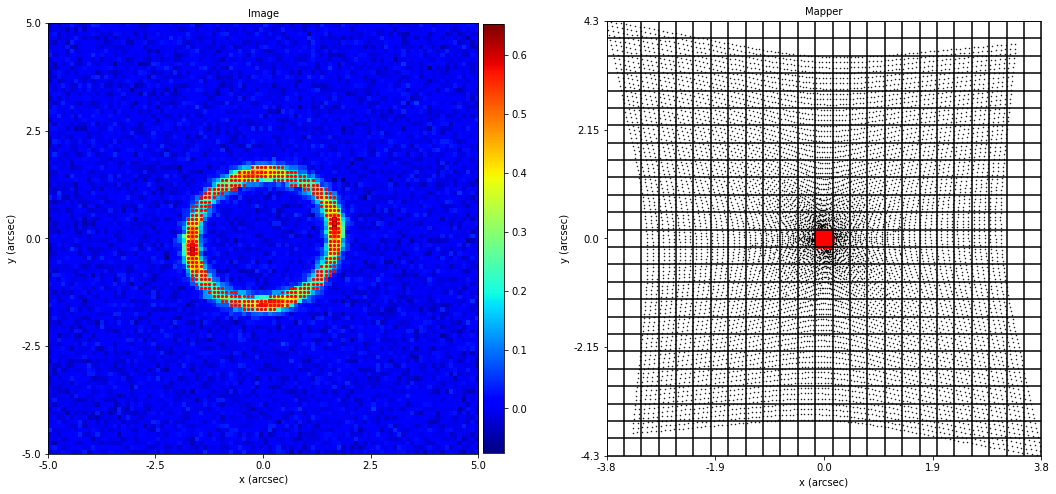

In [8]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[312]])
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

And there we have it, multiple imaging in all its glory. Try changing the source-pixel indexes of the line below. 
This will give you a feel for how different regions of the source-plane map to the image.

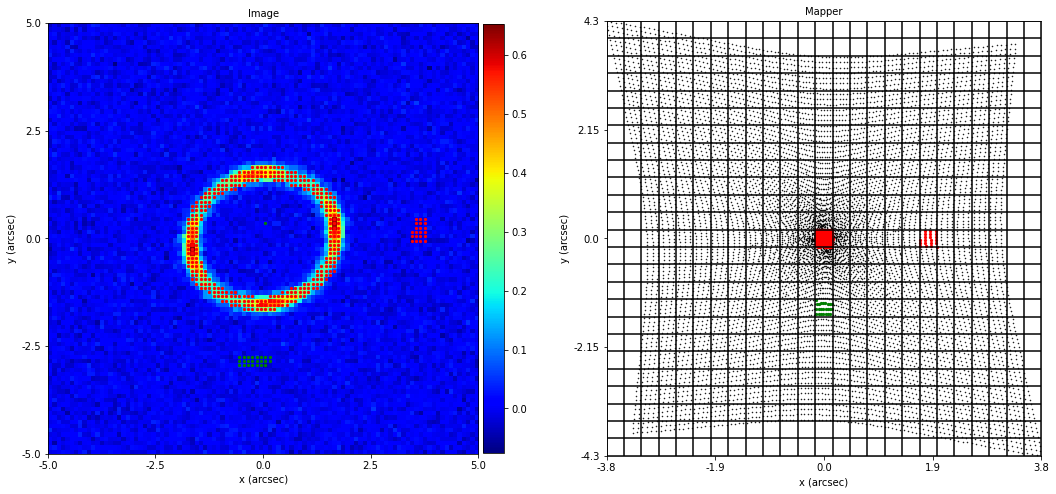

In [9]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[312, 318], [412]])
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

Okay, so I think we can agree, `Mapper`'s map things! More specifically, they map our source-plane pixels to pixels in 
the observed image of a strong lens.

Finally, lets do the same as above, but using a masked image. By applying a `Mask2D`, the `Mapper` will only map 
image-pixels inside the mask. This removes the (many) image pixels at the edge of the image, where the source isn't 
present. These pixels also pad-out the source-plane, thus by removing them our source-plane reduces in size.

Lets just have a quick look at these edges pixels:

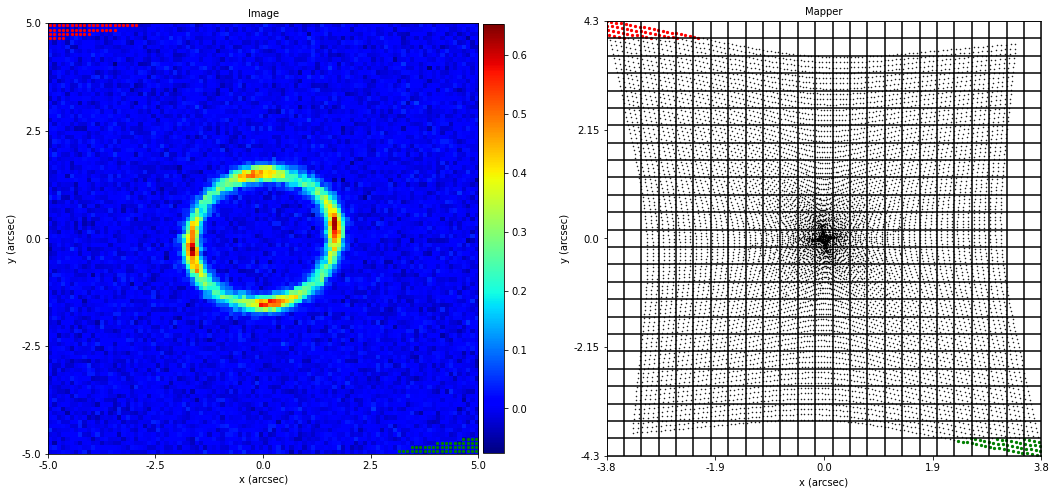

In [10]:
visuals_2d = aplt.Visuals2D(
    pixelization_indexes=[[0, 1, 2, 3, 4, 5, 6, 7], [620, 621, 622, 623, 624]]
)
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

Lets use an annular `Mask2D`, which will capture the ring-like shape of the lensed source galaxy.

In [11]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=1.0,
    outer_radius=2.2,
)

Lets quickly confirm the annuli capture the source's light.

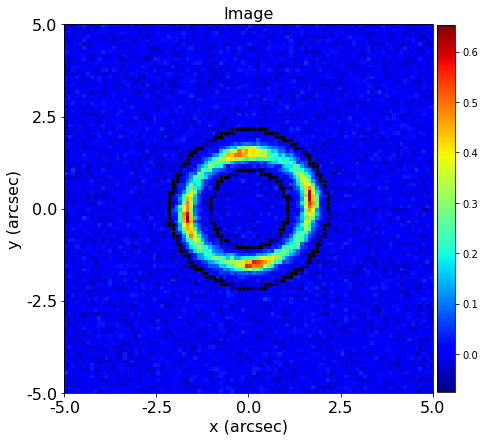

In [12]:
visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures(image=True)

As usual, we setup our `Imaging` and `Mask2D` up as a `MaskedImaging` object and create a `Tracer` using the (masked) 
grid.

In [13]:
masked_imaging = al.MaskedImaging(
    imaging=imaging, mask=mask, settings=al.SettingsMaskedImaging(sub_size=2)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

Finally, we use the masked source-plane `Grid2D` to setup a new `Mapper` (using the same rectangular 25 x 25 
_Pixelization_ as before).

In [14]:
mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Lets have another look.

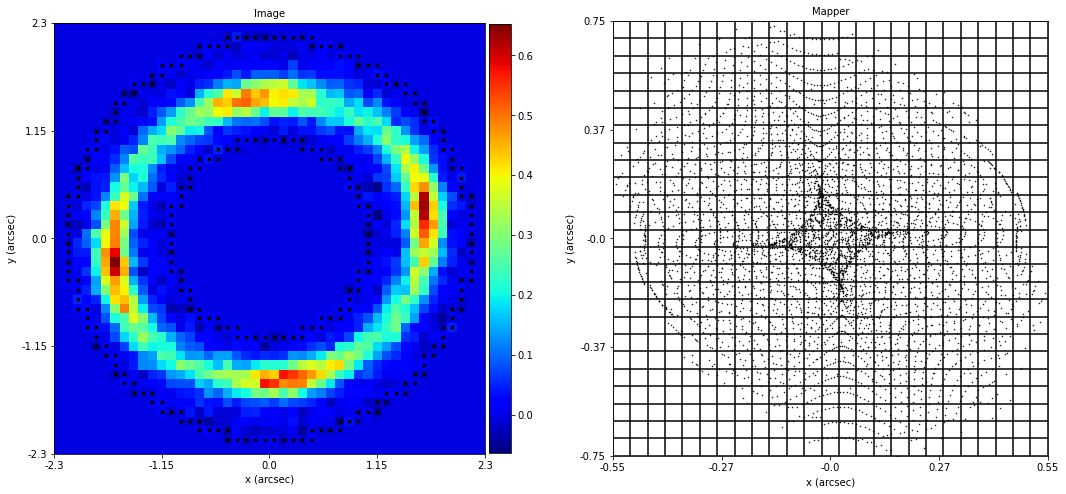

In [15]:
include_2d = aplt.Include2D(mask=True, mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(mapper=mapper, include_2d=include_2d)
mapper_plotter.subplot_image_and_mapper(image=masked_imaging.image)

Woah! Look how much closer we are to the source-plane (The axis sizes have decreased from ~ -2.5" -> 2.5" to 
~ -0.6" to 0.6"). We can now really see the diamond of points in the centre of the source-plane (for those who have 
been reading up, this diamond is called the `caustic`).

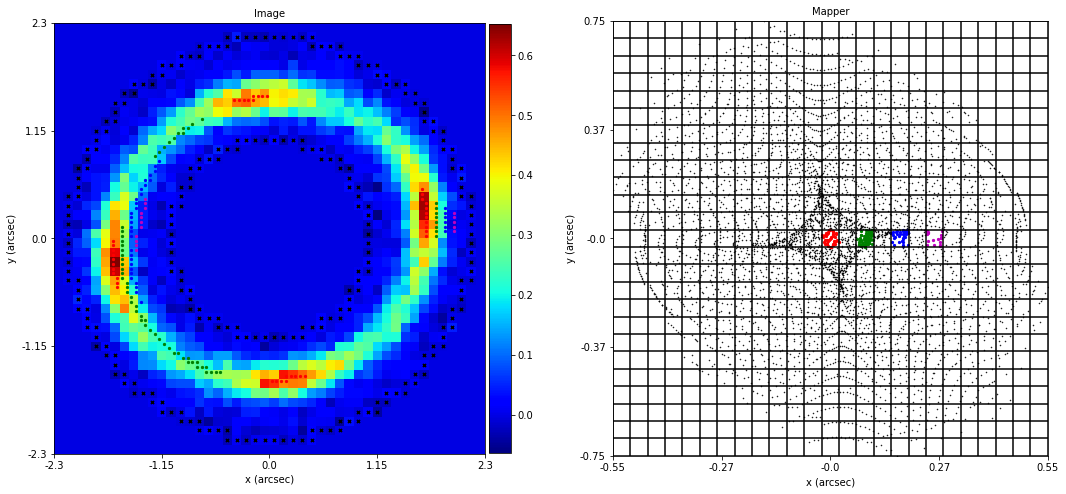

In [16]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[312], [314], [316], [318]])
mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=masked_imaging.image)

Great - tutorial 2 down! We've learnt about `Mapper``., which map things, and we used them to understand how the image 
and source plane map to one another. Your exercises are:

 1) Change the einstein radius of the lens galaxy in small increments (e.g. einstein radius 1.6" -> 1.55"). As the 
 radius deviates from 1.6" (the input value of the simulated lens), what do you notice about where the points map 
 from the centre of the source-plane (where the source-galaxy is simulated, e.g. (0.0", 0.0"))?
    
 2) Incrementally increase the axis ratio of the lens's `MassProfile` to 1.0. What happens to quadruple imaging?
    
 3) Now, finally, think - how is all of this going to help us actually model lenses? We've said we're going to 
 reconstruct our source galaxies on the pixel-grid. So, how does knowing how each pixel maps to the image actually 
 help us? If you`ve not got any bright ideas, then worry not - that exactly what we're going to cover in the next 
 tutorial.